In [1]:
%matplotlib inline
import os
import numpy as np
#import cv2
#from numpy import linalg as LA
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from classifier import *
import matplotlib.pyplot as plt
from sklearn.grid_search import GridSearchCV
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.lda import LDA

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python2.7/dist-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


# Load the Data

In [2]:
#Load data and encode labels
X, y = loadData('data','MOBO')
le = preprocessing.LabelEncoder()
le.fit(np.unique(y))
y = le.transform(y)

## Split Data into Train and Test Set

In [3]:
X = X[0,:,:]
y = y[0,:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

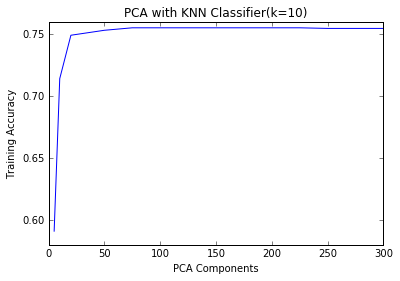

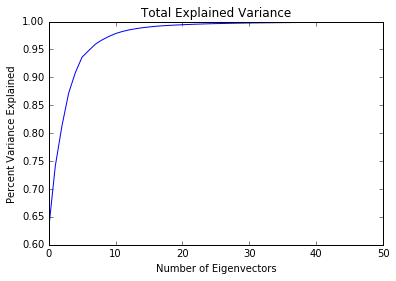

In [4]:
component_grid = [5,10,20,50,75,100,125,150,175,200,225,250,275,300]

scores = []
for num_components in component_grid:
	#Perform PCA on data
	pca = PCA(n_components=num_components)
	pca.fit(X_train)

	#Traing KNN classifier
	neigh = KNeighborsClassifier(n_neighbors=10)
	neigh.fit(pca.transform(X_train),y_train)

	#Test the classifier
	reduced = pca.transform(X_train)
	score =  neigh.score(reduced,y_train)
	scores.append(score)

plt.plot(component_grid,scores)
plt.xlabel('PCA Components')
plt.ylabel('Training Accuracy')
plt.title('PCA with KNN Classifier(k=10)')

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_)[0:50])
plt.title('Total Explained Variance')
plt.xlabel('Number of Eigenvectors')
plt.ylabel('Percent Variance Explained')

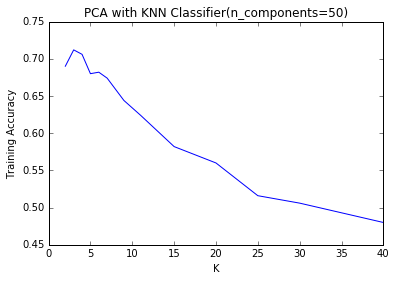

In [5]:
neighbor_grid = [2,3,4,5,6,7,9,11,15,20,25,30,40]
pca = PCA(n_components=50)
pca.fit(X_train)

scores = []
for neighbors in neighbor_grid: 
    clf = KNeighborsClassifier(n_neighbors=neighbors)
    clf.fit(pca.transform(X_train),y_train)
    
    reduced = pca.transform(X_test)
    score = clf.score(reduced,y_test)
    scores.append(score)
    
plt.plot(neighbor_grid,scores)
plt.xlabel('K')
plt.ylabel('Training Accuracy')
plt.title('PCA with KNN Classifier(n_components=50)')

## GridSearch for Best KNN Classifier

In [6]:
component_grid = [5,10,20,50,75,100,125,150,175,200,225,250,275,300]
neighbor_grid = [2,3,4,5,6,7,9,11,15,20,25,30,40]

estimators = [('reduce_dim', PCA()), ('knn', KNeighborsClassifier())]
clf = Pipeline(estimators)

params = {'reduce_dim__n_components':neighbor_grid,
          'knn__n_neighbors':component_grid}

grid_search = GridSearchCV(clf,param_grid=params)
grid_search.fit(X_train,y_train)

print grid_search.score(X_test,y_test)
print grid_search.best_params_

0.684
{'knn__n_neighbors': 5, 'reduce_dim__n_components': 40}


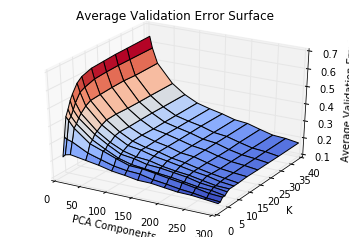

In [7]:
X, Y = np.meshgrid(component_grid,neighbor_grid)
Z = np.zeros(X.shape)

k=0
j=0
for i in xrange(len(grid_search.grid_scores_)):
    score = grid_search.grid_scores_[i][1]
    Z[j,k] = score
    j += 1
    
    if(j==13):
        j = 0
        k += 1
        
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z,rstride=1, cstride=1,cmap=cm.coolwarm)
ax.set_title('Average Validation Error Surface')
ax.set_xlabel('PCA Components')
ax.set_ylabel('K')
ax.set_zlabel('Average Validation Error')

## GridSearch for Best SVM Classifier

In [8]:
component_grid = [5,10,20,50,75,100,125,150,175,200,225,250,275,300]

estimators = [('reduce_dim', PCA()), ('svm', svm.SVC())]
clf = Pipeline(estimators)

params = {'reduce_dim__n_components':neighbor_grid,
          'svm__kernel':('linear', 'rbf'),
          'svm__C':[1,3,5,7,10,15]}

grid_search = GridSearchCV(clf,param_grid=params)
grid_search.fit(X_train,y_train)

print grid_search.score(X_test,y_test)

0.022


# LDA Decomposition

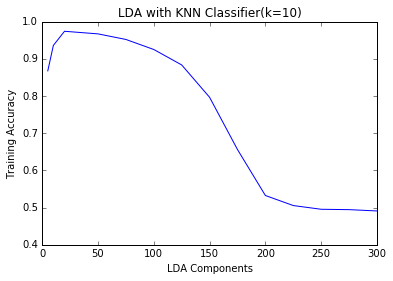

In [9]:
component_grid = [5,10,20,50,75,100,125,150,175,200,225,250,275,300]

scores = []
for num_components in component_grid:
	#Perform PCA on data
	pca = LDA(solver='eigen',n_components=num_components)
	pca.fit(X_train,y_train)

	#Traing KNN classifier
	neigh = KNeighborsClassifier(n_neighbors=10)
	neigh.fit(pca.transform(X_train),y_train)

	#Test the classifier
	reduced = pca.transform(X_train)
	score =  neigh.score(reduced,y_train)
	scores.append(score)

plt.plot(component_grid,scores)
plt.xlabel('LDA Components')
plt.ylabel('Training Accuracy')
plt.title('LDA with KNN Classifier(k=10)')

## GridSearch for Best KNN Classifier

In [10]:
component_grid = [5,10,20,50,75,100]
neighbor_grid = [2,3,4,5,6,7,9,11,15,20,25,30,40]

estimators = [('reduce_dim', LDA(solver='eigen')), ('knn', KNeighborsClassifier())]
clf = Pipeline(estimators)

params = {'reduce_dim__n_components':neighbor_grid,
          'knn__n_neighbors':component_grid}

grid_search = GridSearchCV(clf,param_grid=params)
grid_search.fit(X_train,y_train)

print grid_search.score(X_test,y_test)
print grid_search.best_params_

0.862
{'knn__n_neighbors': 5, 'reduce_dim__n_components': 15}


/usr/local/lib/python2.7/dist-packages/sklearn/discriminant_analysis.py:453: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


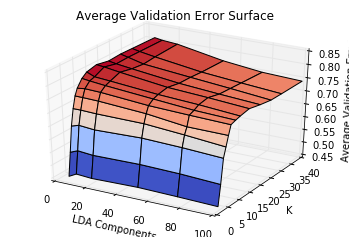

In [11]:
X, Y = np.meshgrid(component_grid,neighbor_grid)
Z = np.zeros(X.shape)

k=0
j=0
for i in xrange(len(grid_search.grid_scores_)):
    score = grid_search.grid_scores_[i][1]
    Z[j,k] = score
    j += 1
    
    if(j==13):
        j = 0
        k += 1
        
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z,rstride=1, cstride=1,cmap=cm.coolwarm)
ax.set_title('Average Validation Error Surface')
ax.set_xlabel('LDA Components')
ax.set_ylabel('K')
ax.set_zlabel('Average Validation Error')

## GridSearch for Best SVM Classifier

In [13]:
component_grid = [5,10,20,50,75,100]

estimators = [('reduce_dim', LDA()), ('svm', svm.SVC())]
clf = Pipeline(estimators)

params = {'reduce_dim__n_components':neighbor_grid,
          'svm__kernel':('linear', 'rbf'),
          'svm__C':[1,3,5,7,10,15]}

grid_search = GridSearchCV(clf,param_grid=params)
grid_search.fit(X_train,y_train)

print grid_search.score(X_test,y_test)

0.84
